<h1><b>인공지능개론 5주차 과제1(kc_house_data)<br></b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h1><b>1. 딥러닝 회귀(kc_house_data.csv)<br></b></h1>

---



<h2><b>1-0. 라이브러리 import(회귀)</b></h2>

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#하이퍼 파라미터 튜닝
!pip install -q keras-tuner
from kerastuner.tuners import RandomSearch
from keras_tuner import HyperParameters

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import SGD,Adam
import tensorflow.keras as keras
import tensorflow as tf

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

<h2><b>1-1. 데이터 로딩</b></h2>

In [15]:
# url을 통해 CSV 파일 읽기
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/kc_house_data.csv" #kc_house_data.csv의 url입력
df = pd.read_csv(url)

# 데이터프레임 확인
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [16]:
# 컬렴명 확인
print(df.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


<h2><b>1-2. 결측치 확인</b></h2>

In [17]:
# 결측치 확인
print(df.isnull().sum())
# 확인 결과: 결측치가 확인되지않음

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


<h2><b>1-3. 레이블 확인(imbalanced data)</b></h2>
<li>타겟 변수(price)의 분포를 확인</li>

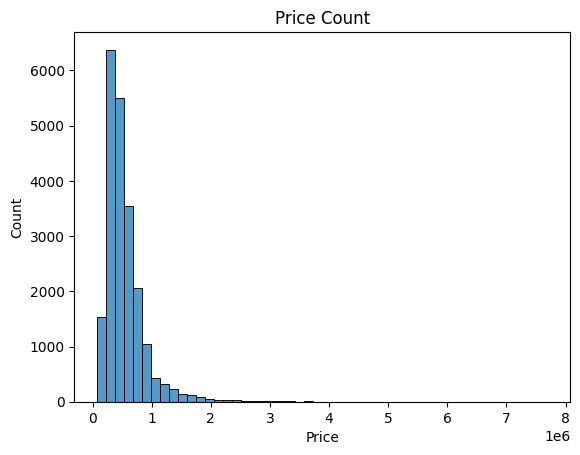

,count
price,
450000.0,172
350000.0,172
550000.0,159
500000.0,152
425000.0,150
...,...
280400.0,1
118000.0,1
202200.0,1


In [18]:
# 레이블 갯수 확인 (그래프)
sns.histplot(df['price'], bins=50) #price가 연속형이므로 분류에서 쓰이는 countplot 대신hisplot사
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Count")
plt.show()

# 레이블 갯수 확인 (숫자)
df['price'].value_counts()


<h2><b>1-4. 데이터 전처리</b></h2>

In [19]:
#1. 데이터 불러오기는 이미 위에서 실향
#2. 불필요한 열 제거
df = df.drop(columns = ['id','date'])

#3. 타겟 변수와 입력 변수 분리
X = df.drop(columns=['price'])
y = df['price']

#4. 범주형 데이터 원-핫 인코딩 (zipcode)
X = pd.get_dummies(X, columns=['zipcode'], drop_first = True)

#5. 학습/테스트 데이터 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#6. 특성 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#7. 확인
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (17290, 86)
X_test shape: (4323, 86)
y_train shape: (17290,)
y_test shape: (4323,)


<h2><b>1-5. 모델 구성&컴파일(하이퍼 파라미터 튜닝을 이용하여)</b></h2>

In [20]:
# 1. 모델 생성 함수 정의
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units1', min_value=32, max_value=256, step=32),
                    activation='relu',
                    input_shape=(X_train.shape[1],)))
    model.add(Dense(hp.Int('units2', min_value=16, max_value=128, step=16),
                    activation='relu'))
    model.add(Dense(1))  # 회귀

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        ),
        loss='mse',
        metrics=['mae']
    )
    return model

# 2. HyperParameters 수동 설정
hp = HyperParameters()
hp.values['units1'] = 64
hp.values['units2'] = 32
hp.values['learning_rate'] = 0.001

# 3. 모델 생성 및 요약 출력
model = build_model(hp)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           5,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

<h2><b>1-6. 모델 학습 </b></h2>

In [21]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 426316955648.0000 - mae: 538376.9375 - val_loss: 393880666112.0000 - val_mae: 532127.4375
Epoch 2/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 408986222592.0000 - mae: 531840.8750 - val_loss: 363334172672.0000 - val_mae: 513842.2188
Epoch 3/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 388275339264.0000 - mae: 510705.8438 - val_loss: 300020006912.0000 - val_mae: 472547.7500
Epoch 4/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 303099838464.0000 - mae: 461456.8750 - val_loss: 217911951360.0000 - val_mae: 407924.0000
Epoch 5/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 219894251520.0000 - mae: 392362.1562 - val_loss: 147981598720.0000 - val_mae: 334168.3125
Epoch 6/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 145320148992.0000 - mae: 319472.8438 - val_loss: 104991522816.0000 - val_mae: 278384.2812
Epoch 7/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 105745776640.0000 - mae: 270009.8

<h2><b>1-7. 시각화 </b></h2>

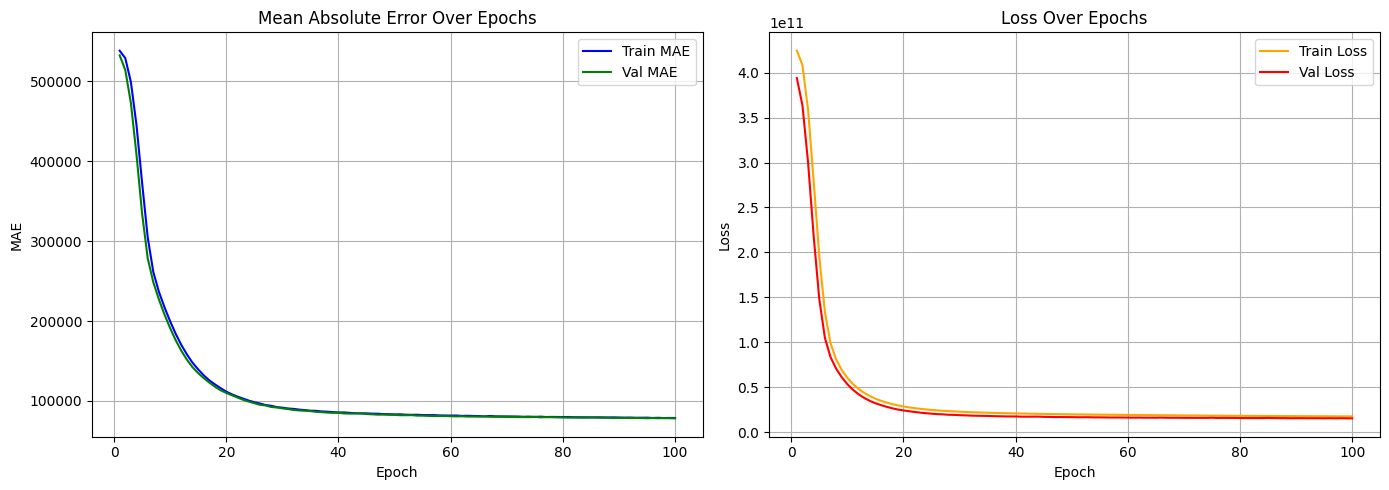

In [22]:
# 데이터 불러오기
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

# Subplot 생성
plt.figure(figsize=(14, 5))

# MAE 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b', label='Train MAE')
plt.plot(epochs, val_mae, 'g', label='Val MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'orange', label='Train Loss')
plt.plot(epochs, val_loss, 'red', label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 전체 그래프 출력
plt.tight_layout()
plt.show()


## 📌 MAE vs MSE(Loss)의 차이

`Mean Absolute Error (MAE)`와 `Mean Squared Error (MSE)`는 모두 회귀 모델의 성능을 평가할 때 사용되지만, 계산 방식과 민감도에서 차이가 있다.

---

### ✅ 1. Mean Absolute Error (MAE)

- 정의:  
  $$
  MAE = \frac{1}{n} \sum |y_{true} - y_{pred}|
  $$
- **예측 오차의 절댓값 평균**
- 평균적으로 **얼마나 틀렸는가?**를 직관적으로 보여줌
- 이상치에 **덜 민감**

---

### ✅ 2. Mean Squared Error (MSE) — 일반적으로 `loss='mse'`

- 정의:  
  $$
  MSE = \frac{1}{n} \sum (y_{true} - y_{pred})^2
  $$
- **오차의 제곱 평균**
- **오차가 클수록 더 큰 패널티 부여**
- 이상치에 **매우 민감**

---

### 📊 예시 비교

| 항목        | MAE                                  | MSE (Loss)                          |
|-------------|---------------------------------------|--------------------------------------|
| 측정 방식   | 오차의 절댓값                        | 오차의 제곱                          |
| 값의 영향력 | 모든 오차가 동일한 영향력             | **큰 오차일수록** 훨씬 더 크게 반영됨 |
| 민감도      | 이상치에 덜 민감함                    | 이상치에 **매우 민감**                |
| 그래프 형태 | 완만한 곡선일 수 있음                 | 중간에 **튀는 곡선**이 나올 수 있음   |

---

### 🔍 실제로는 어떻게 다른가요?

- 예측이 안정적일수록 MAE와 MSE 그래프는 유사
- **일부 예측이 많이 벗어난 경우**, MSE 그래프가 더 요동치거나 값이 더 큼

---

### ✅ 결론

> - `MAE`: 직관적인 평균 오차 측정 지표
> - `MSE`: 모델이 이상치에 얼마나 민감하게 반응하는지 보여줌



MAE와 MSE의 그래프가 유사하므로 예측이 안정적이라고 볼 수 있다.

<h2><b>1-8. 예측 및 시각화 </b></h2>

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


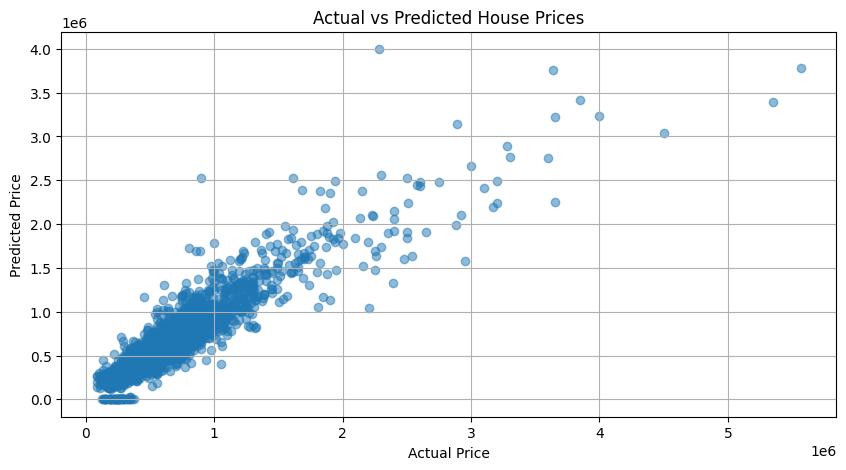

In [23]:
# 예측
y_pred = model.predict(X_test)

# 비교 시각화
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.show()

<h2><b>1-8. 테스트 데이터 평가 </b></h2>

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 예측
y_pred = model.predict(X_test)

# 원래의 테스트 타겟 (Series → NumPy 배열)
y_test_original = y_test.values
y_pred_original = y_pred.flatten()  # (n, 1) → (n,)

# 평가 지표 계산
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

# 결과 출력
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")  # 1에 가까울수록 좋음


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE: 21379640655.88
MAE: 83237.58
R² Score: 0.86
